In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("ksi_collisions.csv")

In [3]:
df.sample(2)

,DATE,STREET1,STREET2,DISTRICT,LATITUDE,LONGITUDE,VISIBILITY,LIGHT,ROAD_CONDITION,ACCLASS,...,DOW,HOUR,YEAR,MONTH,SEVERE_COLLISION,TIME_OF_DAY,SEASON,VEHICLE_TYPE,DRIVER_ACTION,IMPACT_TYPE
9005,2012-12-12,PARLIAMENT ST,KING ST E,Toronto and East York,43.652720,-79.363239,Clear,Dark,Dry,Non-Fatal Injury,...,Wednesday,6,2012,12,0,LateNight,Winter,Car,Other/Unknown,T-Bone
13659,2017-08-01,GRANGE AVE,LARCH ST,Toronto and East York,43.652007,-79.396526,Clear,Daylight,Dry,Non-Fatal Injury,...,Tuesday,17,2017,8,1,Evening,Summer,Two Wheeler,Other/Unknown,Pedestrian/Cyclist


In [73]:
categorical_features = ['ROAD_CONDITION', 'DOW', 'TIME_OF_DAY', 'SEASON', 'VEHICLE_TYPE', 'DRIVER_ACTION', 'IMPACT_TYPE']

In [74]:
target = 'SEVERE_COLLISION'

In [75]:
X = df[categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=60,
        max_depth=4,
        random_state=42,
        n_jobs=-1
    ))
])

In [77]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [78]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73      2021
           1       0.69      0.51      0.59      1725

    accuracy                           0.67      3746
   macro avg       0.68      0.66      0.66      3746
weighted avg       0.68      0.67      0.66      3746



In [79]:
model.score(X_test, y_test)

0.6713828083288842

In [80]:
sample = {
    'LIGHT': 'Daylight',
    'VISIBILITY': 'Clear',
    'ROAD_CONDITION': 'Dry',
    'DOW': 'Friday',
    'TIME_OF_DAY': 'Evening',
    'SEASON': 'Summer',
    'VEHICLE_TYPE': 'Car',
    'DRIVER_ACTION': 'Failed to Yield Right of Way',
    'IMPACT_TYPE': 'T-Bone'
}

sample_df = pd.DataFrame([sample])

In [81]:
prediction = model.predict(sample_df)[0]
probability = model.predict_proba(sample_df)[0][1]
print(f"Predicted class: {prediction} (1 = Severe, 0 = Not Severe)")
print(f"Probability of severe collision: {probability:.3f}")

Predicted class: 0 (1 = Severe, 0 = Not Severe)
Probability of severe collision: 0.399


In [82]:
y_proba = model.predict_proba(df)[:, 1]

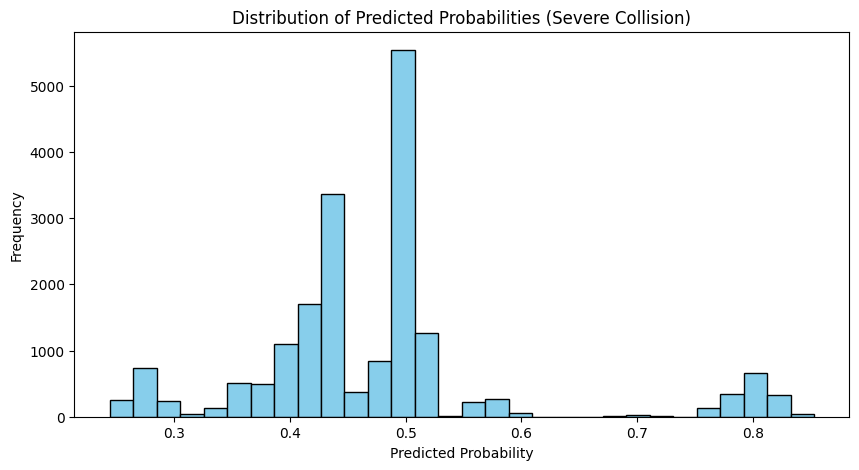

In [83]:
plt.figure(figsize=(10,5))
plt.hist(y_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities (Severe Collision)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [84]:
results = X_test.copy()
results["True_Label"] = y_test.values
results["Predicted"] = y_pred